# Analysis: Final Score Distribution of a "Lambda" League

This notebook tackles a complex problem: what is the distribution of the *winning score* in a league of `n_players`?

We use our most realistic simulation engine (`simulate_full_league`) to model an entire league of 'Lambda Players' (who bet based on the pool average) thousands of times. 

The goal is to find the **true, correlated distribution of the winning score**. This distribution becomes the target to beat.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm.notebook import tqdm
import sys
import os

# Add the parent directory to the path to import our custom module
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from mpp_project.simulation import simulate_single_player_score, simulate_full_league
from mpp_project.strategies import strat_typical_opponent

In [6]:
# --- Configuration ---

# Number of simulations to run (number of tournaments to simulate)
n_samples = 15000
# Number of players in the league
n_players = 12

# --- Match Simulation Parameters ---
match_params = {
    'ev_avg': 35,
    'n_matches': 51,
    'draw_fact_min': 0.2,
    'draw_fact_max': 0.75,
    'outsider_fact_min': 1/7.5,
    'outsider_fact_max': 1.0
}

## Part 1: Distribution of a *Single* Lambda Player (D_lambda)

First, we simulate one 'Lambda Player' (typical opponent) many times to find their typical score distribution, `D_lambda`.

In [7]:
# --- 1. Run the Monte Carlo Simulation for a Single Lambda Player ---
print(f"Running {n_samples:,} simulations of a single Lambda player...")

scores_single_player = [simulate_single_player_score(
                            n_matches=match_params['n_matches'], 
                            match_params=match_params, 
                            strategy_func=strat_typical_opponent
                        ) for _ in tqdm(range(n_samples))]

print("Simulation complete.")

Running 15,000 simulations of a single Lambda player...


  0%|          | 0/15000 [00:00<?, ?it/s]

Simulation complete.


Distribution of a Single Lambda Player's Final Score:
Mean:   1770.31
Std.Dev: 301.15


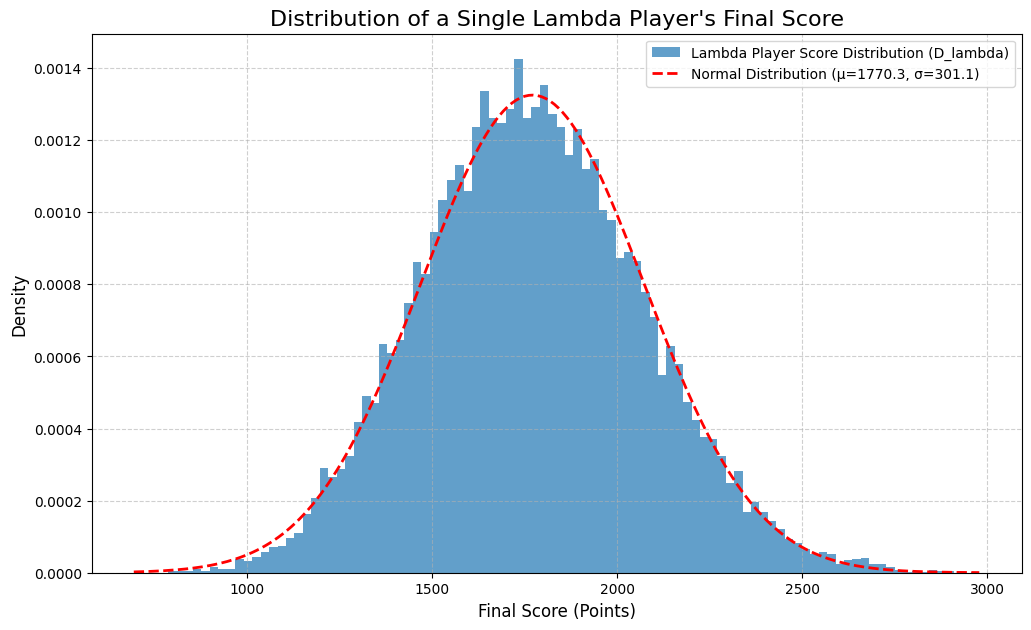

In [8]:
# --- 2. Analyze & Plot the Single Player Distribution (D_lambda) ---

score_mean = np.mean(scores_single_player)
score_std = np.std(scores_single_player)

print(f"Distribution of a Single Lambda Player's Final Score:")
print(f"Mean:   {score_mean:.2f}")
print(f"Std.Dev: {score_std:.2f}")

plt.figure(figsize=(12, 7))
plt.hist(scores_single_player, bins=100, density=True, alpha=0.7, label="Lambda Player Score Distribution (D_lambda)")

# Plot the equivalent Normal distribution (CLT)
x = np.linspace(min(scores_single_player), max(scores_single_player), 200)
y = norm.pdf(x, score_mean, score_std)
plt.plot(x, y, 'r--', linewidth=2, label=f"Normal Distribution (μ={score_mean:.1f}, σ={score_std:.1f})")

plt.title("Distribution of a Single Lambda Player's Final Score", fontsize=16)
plt.xlabel("Final Score (Points)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Part 2: Distribution of the *Winning Score*

Now we do it the correct way. We simulate the *entire league* of `n_players` `n_samples` times, capturing the correlations. We then find the `max` score from each simulated league.

In [ ]:
print(f"Running {n_samples:,} simulations of the *full league* ({n_players} players)...")
winning_scores_correct = []

# Define the strategy list for a full league of lambda players
lambda_league_strategies = [strat_typical_opponent] * n_players

for _ in tqdm(range(n_samples)):
    # Simulate one entire tournament for all N players
    final_league_scores = simulate_full_league(
        n_players=n_players,
        n_matches=match_params['n_matches'], 
        match_params=match_params, 
        player_strategies=lambda_league_strategies
    )
    # Find the winning score and store it
    winning_scores_correct.append(np.max(final_league_scores))

correct_mean = np.mean(winning_scores_correct)
correct_std = np.std(winning_scores_correct)
correct_median = np.median(winning_scores_correct)
correct_p75 = np.percentile(winning_scores_correct, 75)
correct_p90 = np.percentile(winning_scores_correct, 90)

print("\nCorrect Winning Score Distribution:")
print(f"Mean:   {correct_mean:.2f}")
print(f"Median: {correct_median:.2f}")
print(f"75th Percentile: {correct_p75:.2f}")
print(f"90th Percentile: {correct_p90:.2f}")

Running 15,000 simulations of the *full league* (12 players)...


  0%|          | 0/15000 [00:00<?, ?it/s]


Correct Winning Score Distribution:
Mean:   2243.14
Median: 2234.00
75th Percentile: 2376.00 (This is a good 'target score')
90th Percentile: 2508.00


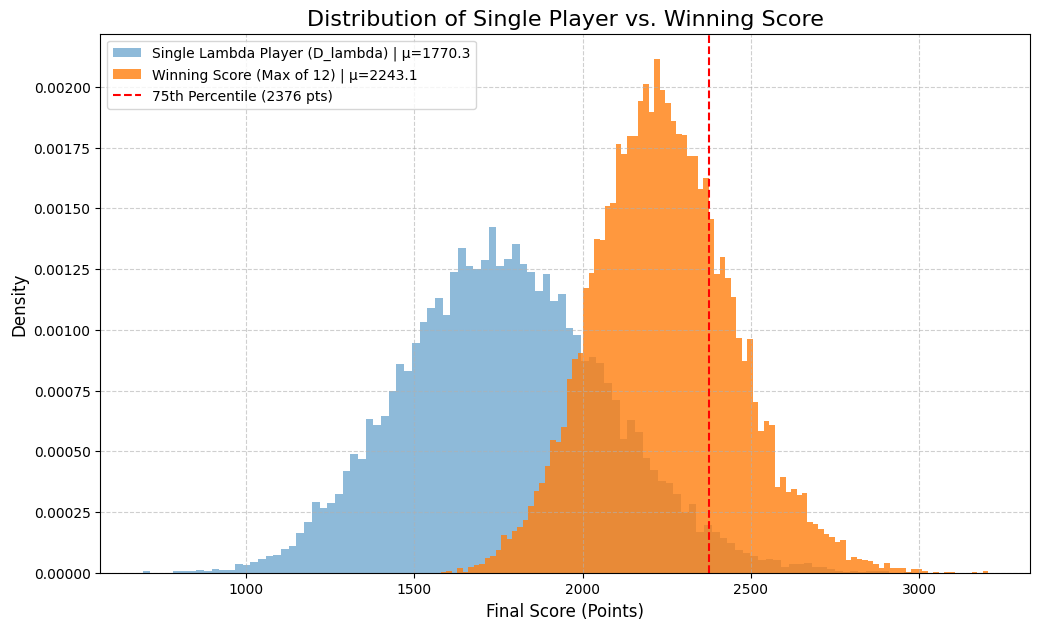

In [11]:
# --- 3. Comparison Plot ---

plt.figure(figsize=(12, 7))
bins = 100

plt.hist(scores_single_player, bins=bins, density=True, alpha=0.5, 
         label=f"Single Lambda Player (D_lambda) | μ={score_mean:.1f}")

plt.hist(winning_scores_correct, bins=bins, density=True, alpha=0.8, 
         label=f"Winning Score (Max of {n_players}) | μ={correct_mean:.1f}")

plt.axvline(correct_p75, color='r', linestyle='--', label=f"75th Percentile ({correct_p75:.0f} pts)")

plt.title("Distribution of Single Player vs. Winning Score", fontsize=16)
plt.xlabel("Final Score (Points)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()